In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.distributions
from msmbuilder.example_datasets import load_quadwell
from msmbuilder.example_datasets import quadwell_eigs
from msmbuilder.cluster import NDGrid
from msmbuilder.msm import MarkovStateModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pa

In [2]:
grids = np.arange(20, 100, 1)
gmrq4 = np.zeros(grids.shape[0])
for row, i in enumerate(grids):
    gmrq4[row] = quadwell_eigs(i)[0][:4].sum()

In [3]:
dataset = [t for t in load_quadwell(random_state=i).trajectories for i in np.arange(10,110,10)]

In [5]:
dataset[0].shape

(1001, 1)

In [4]:
dataset_sh = [t[:10] for t in dataset]

In [10]:
u, rv = quadwell_eigs(300)

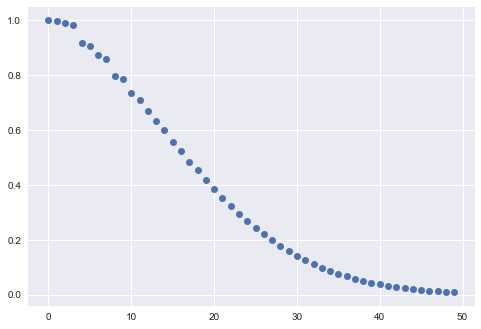

In [15]:
plt.plot(u[:50], marker='o', ls='')

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


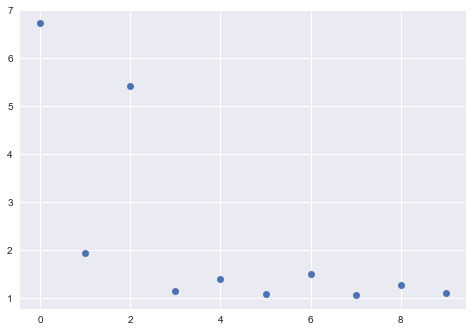

In [16]:
ts = -1/np.log(u[1:])
plt.plot(ts[:10]/ts[1:11], marker='o', ls='')
# plt.yscale('log')

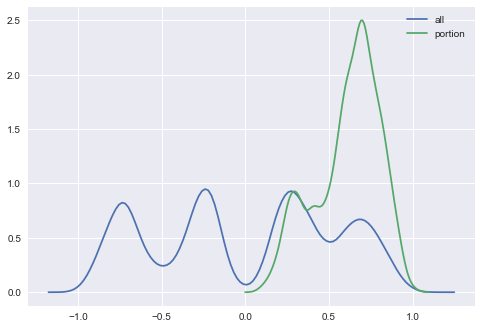

In [17]:
sns.distplot(np.concatenate(dataset), label='all', kde=True, hist=False)
sns.distplot(np.concatenate(dataset[:10]), label='portion', kde=True, hist=False)
plt.legend()

In [19]:
pipeline = Pipeline([
    ('grid', NDGrid(min=-1.2, max=1.2)),
    ('msm', MarkovStateModel(n_timescales=3, reversible_type='transpose', verbose=False)),
])

In [54]:
search = GridSearchCV(pipeline, cv=5, refit=False, 
                      param_grid={'grid__n_bins_per_feature': list(np.arange(100,500,100))})
search.fit(dataset)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('grid', NDGrid(max=1.2, min=-1.2, n_bins_per_feature=2)), ('msm', MarkovStateModel(ergodic_cutoff='on', lag_time=1, n_timescales=3,
         prior_counts=0, reversible_type='transpose', sliding_window=True,
         use_gap=None, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'grid__n_bins_per_feature': [100, 200, 300, 400]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring=None, verbose=0)

In [55]:
df = pd.DataFrame(search.cv_results_)

In [56]:
df.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_grid__n_bins_per_feature,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.453132,0.122198,3.974401,3.975170,100,{'grid__n_bins_per_feature': 100},4,3.976118,3.974662,3.973934,...,3.974508,3.975213,3.974707,3.975109,3.972740,3.975312,0.017724,0.009475,0.001098,0.000294
1,0.459544,0.129462,3.975121,3.976141,200,{'grid__n_bins_per_feature': 200},2,3.977077,3.975617,3.974715,...,3.975315,3.976202,3.975441,3.976056,3.973055,3.976305,0.005772,0.004971,0.001296,0.000304
2,0.470486,0.155194,3.975311,3.976416,300,{'grid__n_bins_per_feature': 300},1,3.977087,3.975869,3.974911,...,3.975448,3.976486,3.975874,3.976333,3.973236,3.976581,0.007098,0.017125,0.001261,0.000314
3,0.516169,0.195802,3.974957,3.976467,400,{'grid__n_bins_per_feature': 400},3,3.977050,3.975915,3.974392,...,3.975335,3.976550,3.975369,3.976372,3.972639,3.976652,0.031723,0.006681,0.001441,0.000315


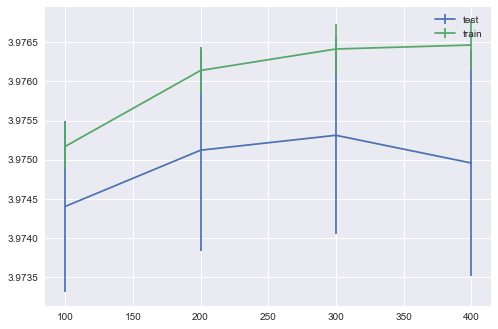

In [57]:
plt.errorbar(df['param_grid__n_bins_per_feature'], df['mean_test_score'],yerr=df['std_test_score'], label='test')
plt.errorbar(df['param_grid__n_bins_per_feature'], df['mean_train_score'],yerr=df['std_train_score'], label='train')
plt.legend()

In [138]:
df.sort_values(by='mean_test_score', inplace=True, ascending=False)

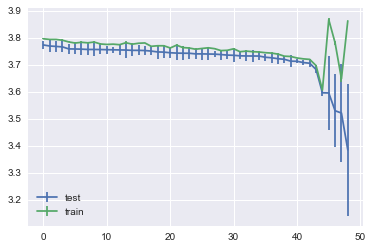

In [139]:
plt.errorbar(np.arange(len(df)), df['mean_test_score'],yerr=df['std_test_score'], label='test')
plt.errorbar(np.arange(len(df)), df['mean_train_score'],yerr=df['std_train_score'], label='train')
plt.legend()

In [58]:
cluster = NDGrid(min=-1.2, max=1.2, n_bins_per_feature=300)

In [59]:
dtrajs = cluster.fit_transform(dataset)

In [60]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [61]:
lags = np.arange(1,1000,20)
its = msm.timescales_msm(dtrajs, lags=lags, nits=10)

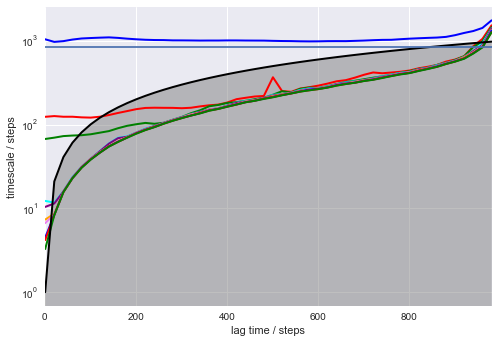

In [67]:
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)
plt.plot(lags, -np.ones(len(lags))/np.log(u[1]))